In [74]:
# Importing files 
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [75]:
# Reading csv file
def read_csv(csv_path="/problems/isolated.csv"):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

In [76]:
# Plotting csv file
def plot(paths_XYs="problems/isolated.csv"):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    path_XYs = read_csv(paths_XYs)
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    plt.show()

In [77]:
def save_to_csv(path_XYs, csv_path):
    rows = []
    for i, shape in enumerate(path_XYs):
        for j, points in enumerate(shape):
            for point in points:
                rows.append([i, j, *point])
    df = pd.DataFrame(rows, columns=['ShapeID', 'SubShapeID', 'X', 'Y'])
    df.to_csv(csv_path, index=False)
    return csv_path

# Main logic of Code

In [78]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def regularize_shape(shape):
    if len(shape) >= 2:
        # Case 1: Shape is a single point or all points are the same
        if np.allclose(np.diff(shape, axis=0), 0, atol=1e-6):
            return shape

        # Case 2: Line or nearly collinear points
        if len(shape) == 2 or np.linalg.matrix_rank(shape[1:] - shape[0]) == 1:
            if len(shape) == 2:
                return shape
            
            reg = LinearRegression()
            X = shape[:, 0].reshape(-1, 1)
            y = shape[:, 1]
            reg.fit(X, y)
            y_pred = reg.predict(X)
            straight_line = np.column_stack((X.flatten(), y_pred))
            return straight_line

        # Case 3: Convex Hull (non-line shapes)
        if len(shape) >= 3:
            hull = ConvexHull(shape)
            hull_points = shape[hull.vertices]

            # Sub-case: Square
            if len(hull_points) == 4:
                hull_points = order_points(hull_points)
                side_length = np.mean([
                    np.linalg.norm(hull_points[0] - hull_points[1]),
                    np.linalg.norm(hull_points[1] - hull_points[2]),
                    np.linalg.norm(hull_points[2] - hull_points[3]),
                    np.linalg.norm(hull_points[3] - hull_points[0])
                ])

                square_points = np.array([
                    [0, 0],
                    [side_length, 0],
                    [side_length, side_length],
                    [0, side_length]
                ])

                def angle_between_points(p1, p2):
                    return np.arctan2(p2[1] - p1[1], p2[0] - p1[0])

                angle = angle_between_points(hull_points[0], hull_points[1])
                rotation_matrix = np.array([
                    [np.cos(angle), -np.sin(angle)],
                    [np.sin(angle), np.cos(angle)]
                ])

                square_points = (rotation_matrix @ square_points.T).T + hull_points[0]
                return hull_points

            # Sub-case: Circle
            elif len(hull_points) > 10:
                x_avg, y_avg = np.mean(shape, axis=0)
                distances = np.linalg.norm(shape - [x_avg, y_avg], axis=1)
                mean_distance = np.mean(distances)
                std_distance = np.std(distances)

                if std_distance / mean_distance < 0.1:
                    radius = mean_distance
                    angles = np.linspace(0, 2 * np.pi, len(shape))
                    circle_points = np.array([[x_avg + radius * np.cos(angle), y_avg + radius * np.sin(angle)] for angle in angles])
                    return circle_points

            # Sub-case: Star
            elif len(hull_points) % 2 == 0:
                distances = np.linalg.norm(np.roll(hull_points, -1, axis=0) - hull_points, axis=1)
                if len(np.unique(distances)) == 2:  # Two distinct distances typical of a star
                    # Normalize the star shape
                    avg_distance = np.mean(distances)
                    angles = np.linspace(0, 2 * np.pi, len(hull_points))
                    star_points = np.array([[x_avg + avg_distance * np.cos(angle), y_avg + avg_distance * np.sin(angle)] for angle in angles])
                    return star_points

            return hull_points

    return shape


def regularize_shapes(path_XYs):
    regularized_shapes = []
    for shape in path_XYs:
        regularized_shape = [regularize_shape(np.array(points)) for points in shape]
        regularized_shapes.append(regularized_shape)
    return regularized_shapes

# From here code will run

In [79]:
path_XYs = read_csv("problems/occlusion1.csv") # Give your csv file here
regularized_shapes = regularize_shapes(path_XYs)
output_path = save_to_csv(regularized_shapes, "output/frag0.csv") # Specify the output location 

# Load and return the regularized coordinates
regularized_coordinates = np.genfromtxt(output_path, delimiter=',')
regularized_coordinates


array([[         nan,          nan,          nan,          nan],
       [  0.        ,   0.        ,  35.38899994, 124.72799683],
       [  0.        ,   0.        ,  82.08300018, 110.55599976],
       ...,
       [  1.        ,   1.        ,  74.27323994,  39.05967558],
       [  1.        ,   1.        ,  74.35517163,  40.07458173],
       [  1.        ,   1.        ,  74.38250847,  41.09242258]])

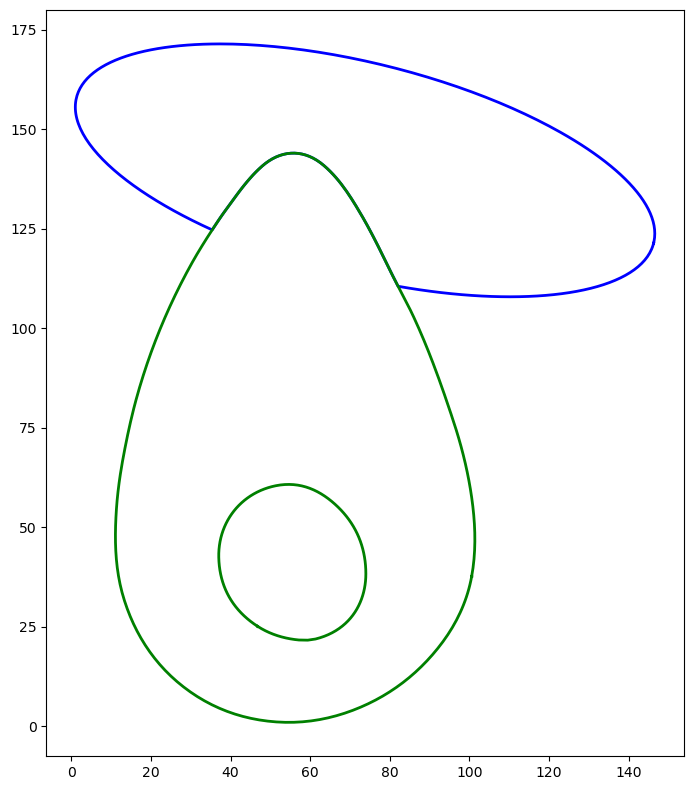

In [80]:
plot("problems/occlusion1.csv")

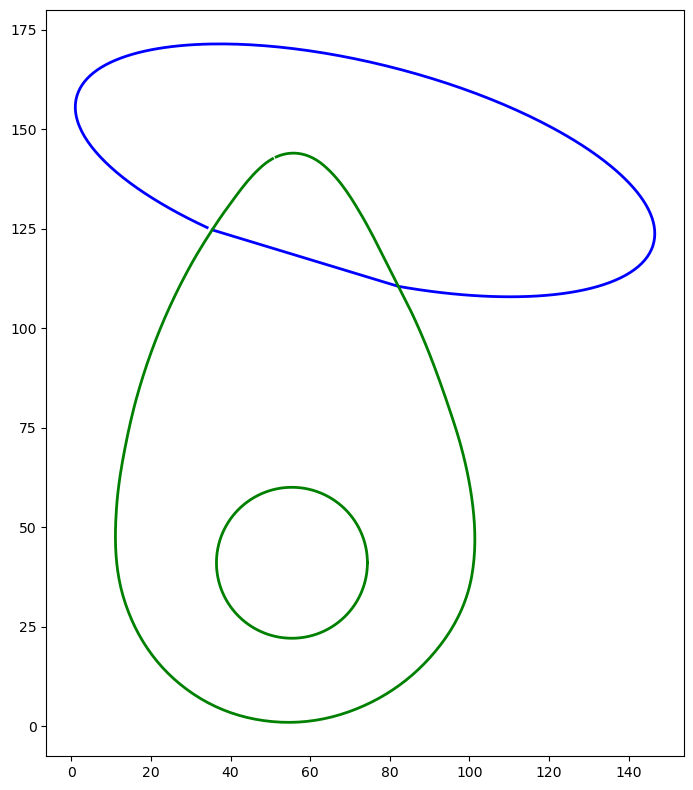

In [81]:
plot("output/frag0.csv")